In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import category_encoders as ce
from sklearn.model_selection import train_test_split


In [2]:
raw_df = pd.read_csv("data/Country-data.csv")
raw_df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [3]:
df=raw_df.copy()
for col in raw_df.columns:
    if col in ['country']: continue
    temp=raw_df[col]#.dropna()
    a=temp.quantile(0.99)-temp.quantile(0.01)
    if a<0.001: a=temp.max()-temp.min()
    df[col] = (df[col]-temp.quantile(0.01))/(temp.quantile(0.99)-temp.quantile(0.01))
np.round(df.describe([0.01,0.99, 0.5, 0.25, 0.75]),3)

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000,167.000,167.000,167.000,167.000,167.000,167.000,167.000,167.000
mean,0.236,0.238,0.413,0.255,0.196,0.231,0.664,0.320,0.160
std,0.268,0.175,0.242,0.182,0.231,0.241,0.253,0.285,0.233
min,-0.001,-0.024,-0.027,-0.097,-0.002,-0.042,-0.428,-0.018,-0.001
1%,0.000,-0.000,-0.000,0.000,0.000,0.000,0.000,-0.000,-0.000
25%,0.036,0.127,0.246,0.129,0.031,0.095,0.515,0.104,0.013
50%,0.110,0.199,0.370,0.228,0.110,0.177,0.737,0.219,0.055
75%,0.394,0.303,0.571,0.344,0.264,0.299,0.842,0.496,0.174
99%,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
max,1.363,1.252,1.390,1.210,1.486,2.427,1.012,1.174,1.329


In [4]:
df=raw_df.copy()
for col in raw_df.columns:
    if col in ['country']: continue
    temp=raw_df[col]#.dropna()
    a=temp.std()
    if a==0: a=1
    df[col] = (df[col]-temp.mean())/a
np.round(df.describe([0.01,0.99, 0.5, 0.25, 0.75]),3)

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000,167.000,167.000,167.000,167.000,167.000,167.000,167.000,167.000
mean,-0.000,0.000,0.000,0.000,-0.000,-0.000,0.000,0.000,0.000
std,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
min,-0.884,-1.496,-1.822,-1.934,-0.858,-1.134,-4.324,-1.188,-0.695
1%,-0.880,-1.357,-1.709,-1.400,-0.851,-0.958,-2.631,-1.126,-0.689
25%,-0.744,-0.631,-0.690,-0.689,-0.715,-0.565,-0.591,-0.762,-0.635
50%,-0.470,-0.223,-0.180,-0.148,-0.373,-0.226,0.286,-0.355,-0.453
75%,0.591,0.374,0.650,0.490,0.293,0.281,0.702,0.616,0.059
99%,2.855,4.355,2.424,4.097,3.487,3.188,1.328,2.388,3.608
max,4.209,5.796,4.035,5.250,5.595,9.102,1.377,3.000,5.021


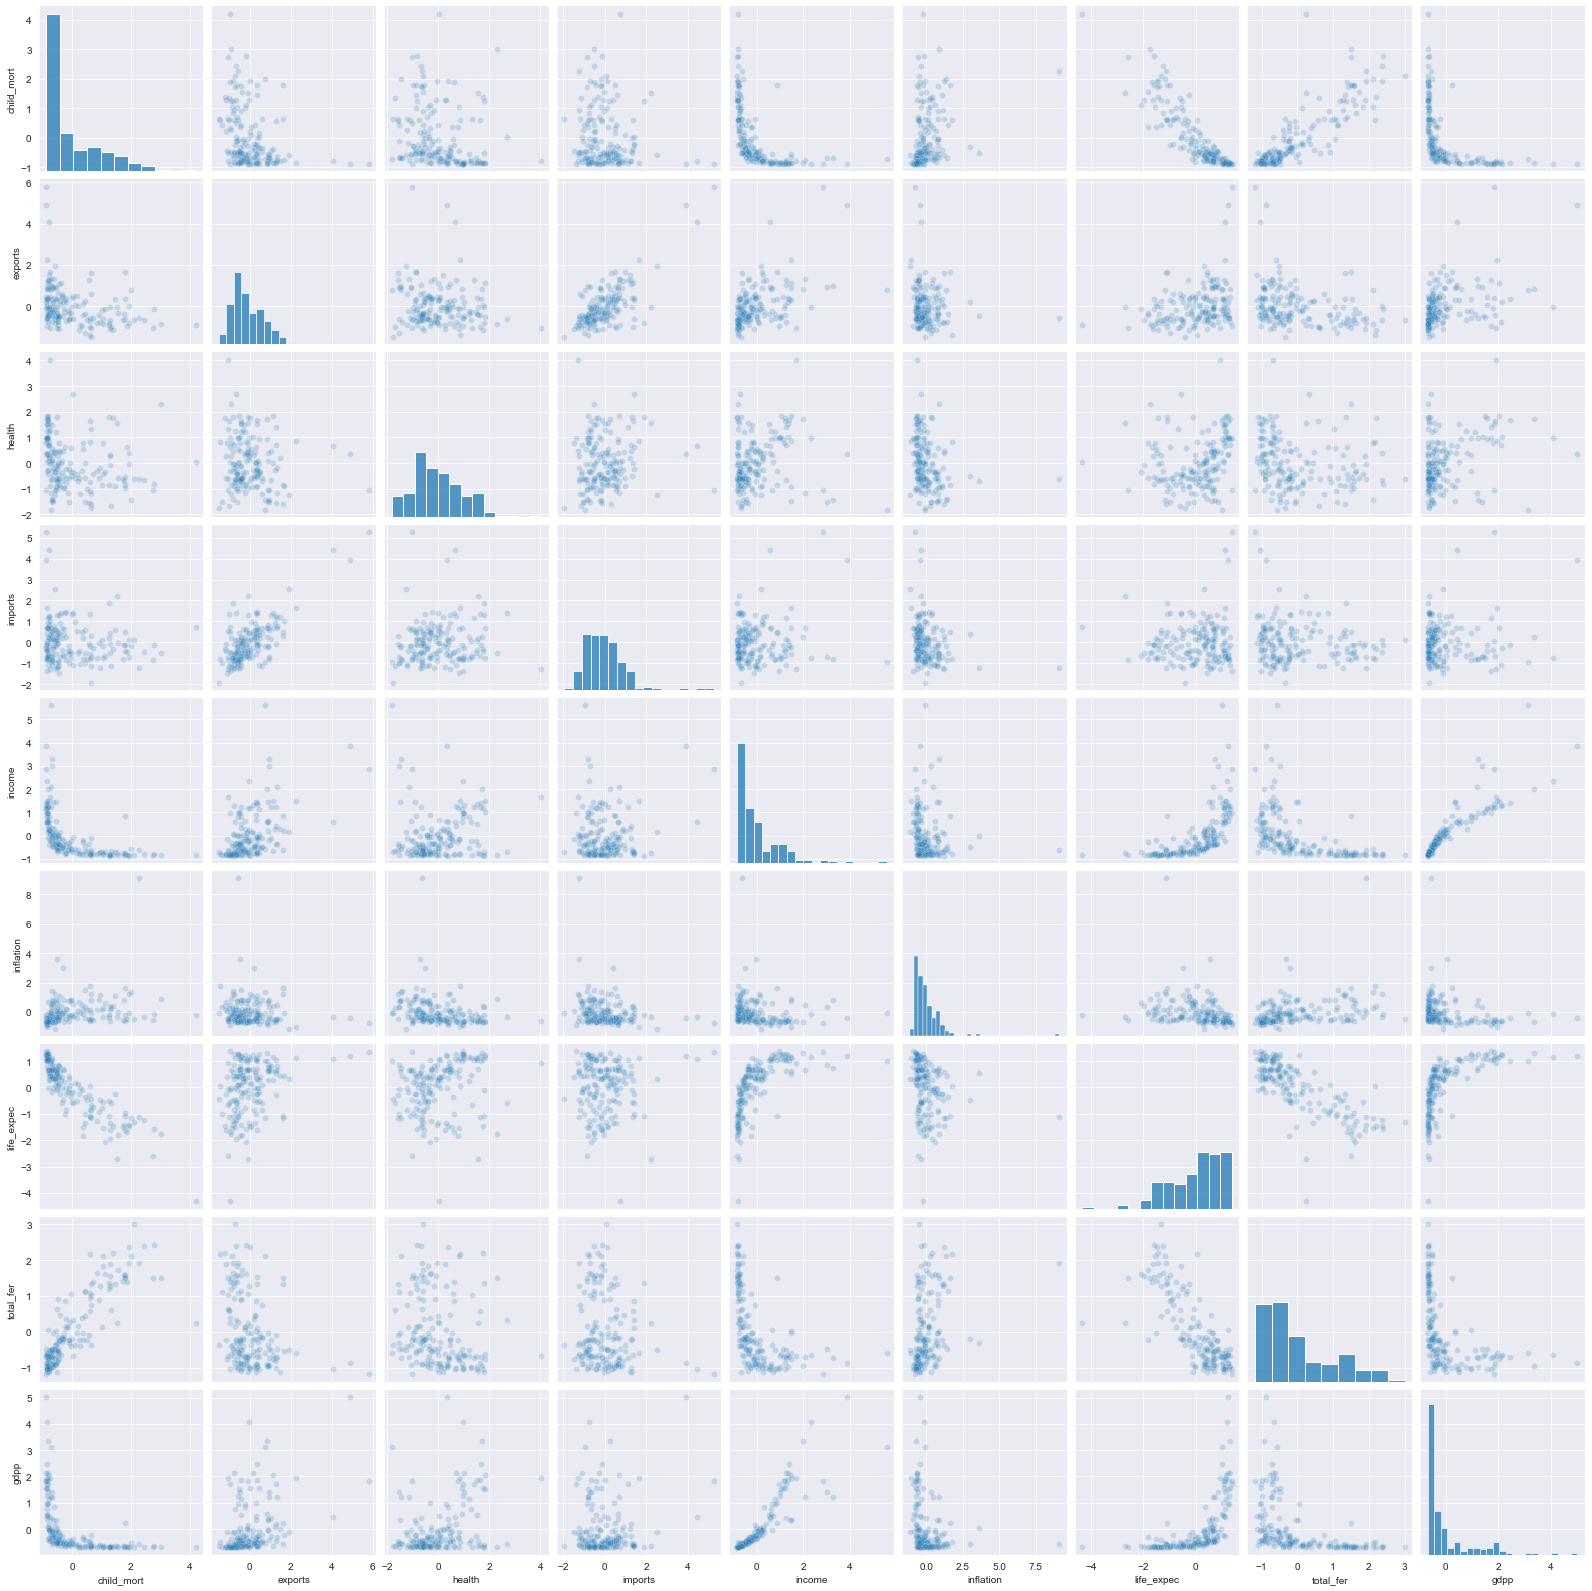

In [5]:
# pairplot drop country with alpha
sns.pairplot(df.drop('country', axis=1), plot_kws={'alpha': 0.2})
plt.show()

C:\Users\No1\AppData\Local\Temp\ipykernel_4376\2157389859.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(abs(df.corr()), annot=True, vmin=0)


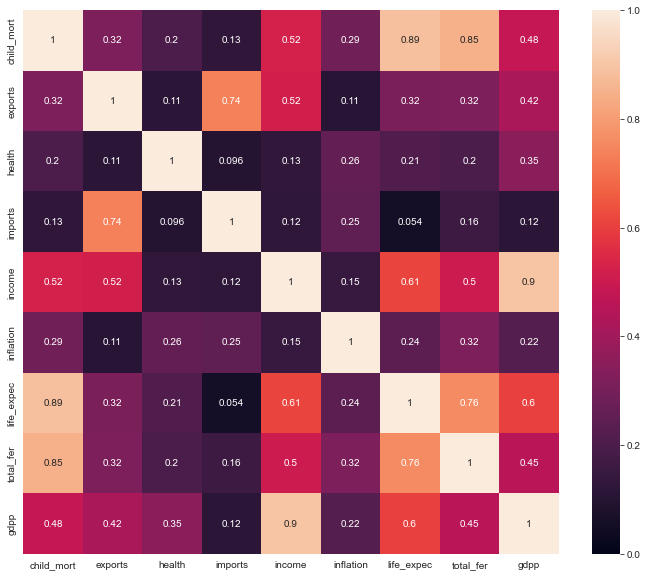

In [6]:
# covariance matrix plot with color bar from 0
plt.figure(figsize=(12,10))
sns.heatmap(abs(df.corr()), annot=True, vmin=0)
plt.show()

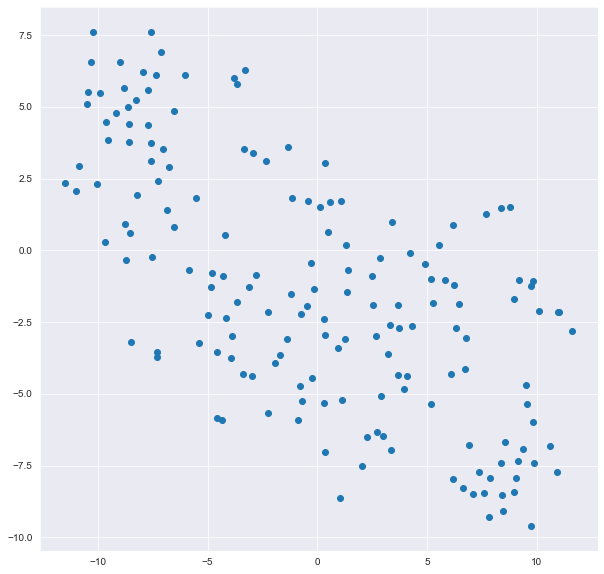

In [7]:
# create tsne plot
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, n_iter=5000)
tsne_obj = tsne.fit_transform(df.drop('country', axis=1))
#plot tsne
plt.figure(figsize=(10,10))
plt.scatter(tsne_obj[:,0], tsne_obj[:,1])
plt.show()


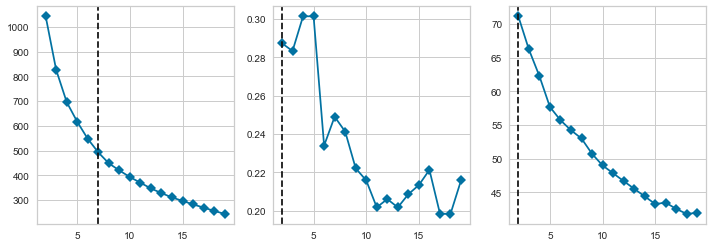

In [8]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
methods = ['distortion', 'silhouette', 'calinski_harabasz']
plt.figure(figsize=(12,4))
for i,me in enumerate(methods):
    # print(me)
    plt.subplot(1, 3, i + 1)
    visualizer = KElbowVisualizer(
        KMeans(n_init=150), k=(2,20), metric = me, timings = False)
    visualizer.fit(df.drop('country', axis=1))
    # visualizer.show()

2 0.287356689214067
3 0.28329575683463126
4 0.301375962376881
5 0.3044077973075222
6 0.23293312221599696
7 0.24905003461730515
8 0.24710895707337308
9 0.23046977222379533
10 0.22949034869251417


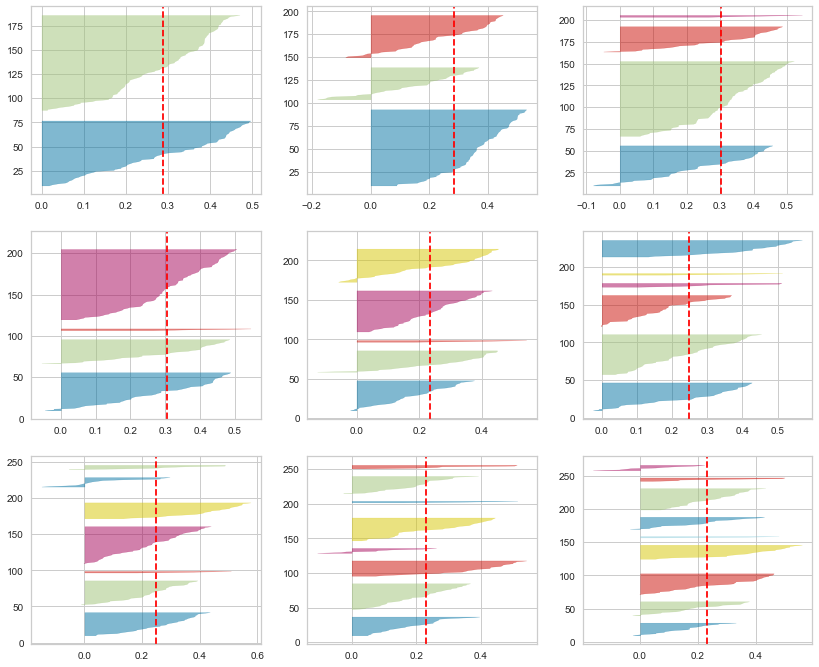

In [9]:
# sub plot
from yellowbrick.cluster import SilhouetteVisualizer
plt.figure(figsize=(14,20))
for k in range(2,11):
    plt.subplot(5, 3, k - 1)
    visualizer = SilhouetteVisualizer(
        KMeans(k, n_init=150), colors='yellowbrick')
    visualizer.fit(df.drop('country', axis=1))
    print(k, visualizer.silhouette_score_)
    # visualizer.show()
    

C:\Users\No1\AppData\Local\Temp\ipykernel_4376\3311498110.py:9: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  sns.scatterplot(


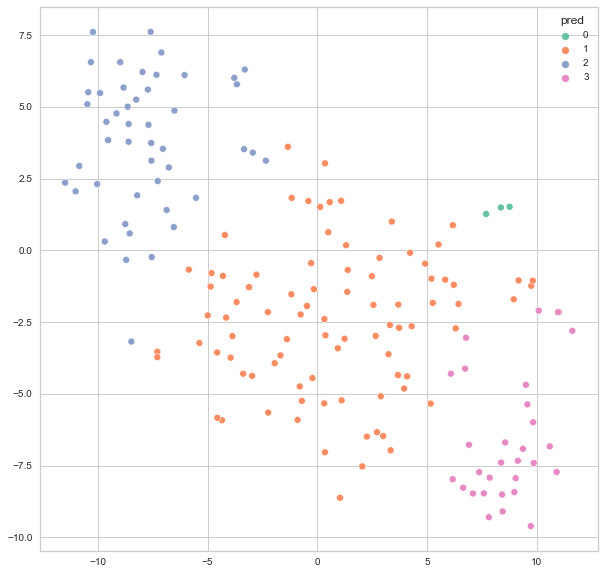

E:\User Applications\Software\Miniconda3\envs\SpikingJelly\lib\site-packages\seaborn\axisgrid.py:1507: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  func(x=vector, **plot_kwargs)
E:\User Applications\Software\Miniconda3\envs\SpikingJelly\lib\site-packages\seaborn\axisgrid.py:1507: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  func(x=vector, **plot_kwargs)
E:\User Applications\Software\Miniconda3\envs\SpikingJelly\lib\site-packages\seaborn\axisgrid.py:1507: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  func(x=vector, **plot_kwargs)
E:\User Applications\Software\Miniconda3\envs\SpikingJelly\lib\site-packages\seaborn\axisgrid.py:1507: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  func(x=vector, **plot_kwargs)
E:\User Applications\Software\Miniconda3\envs\SpikingJelly\lib\site-packages\seaborn

<Figure size 720x720 with 0 Axes>

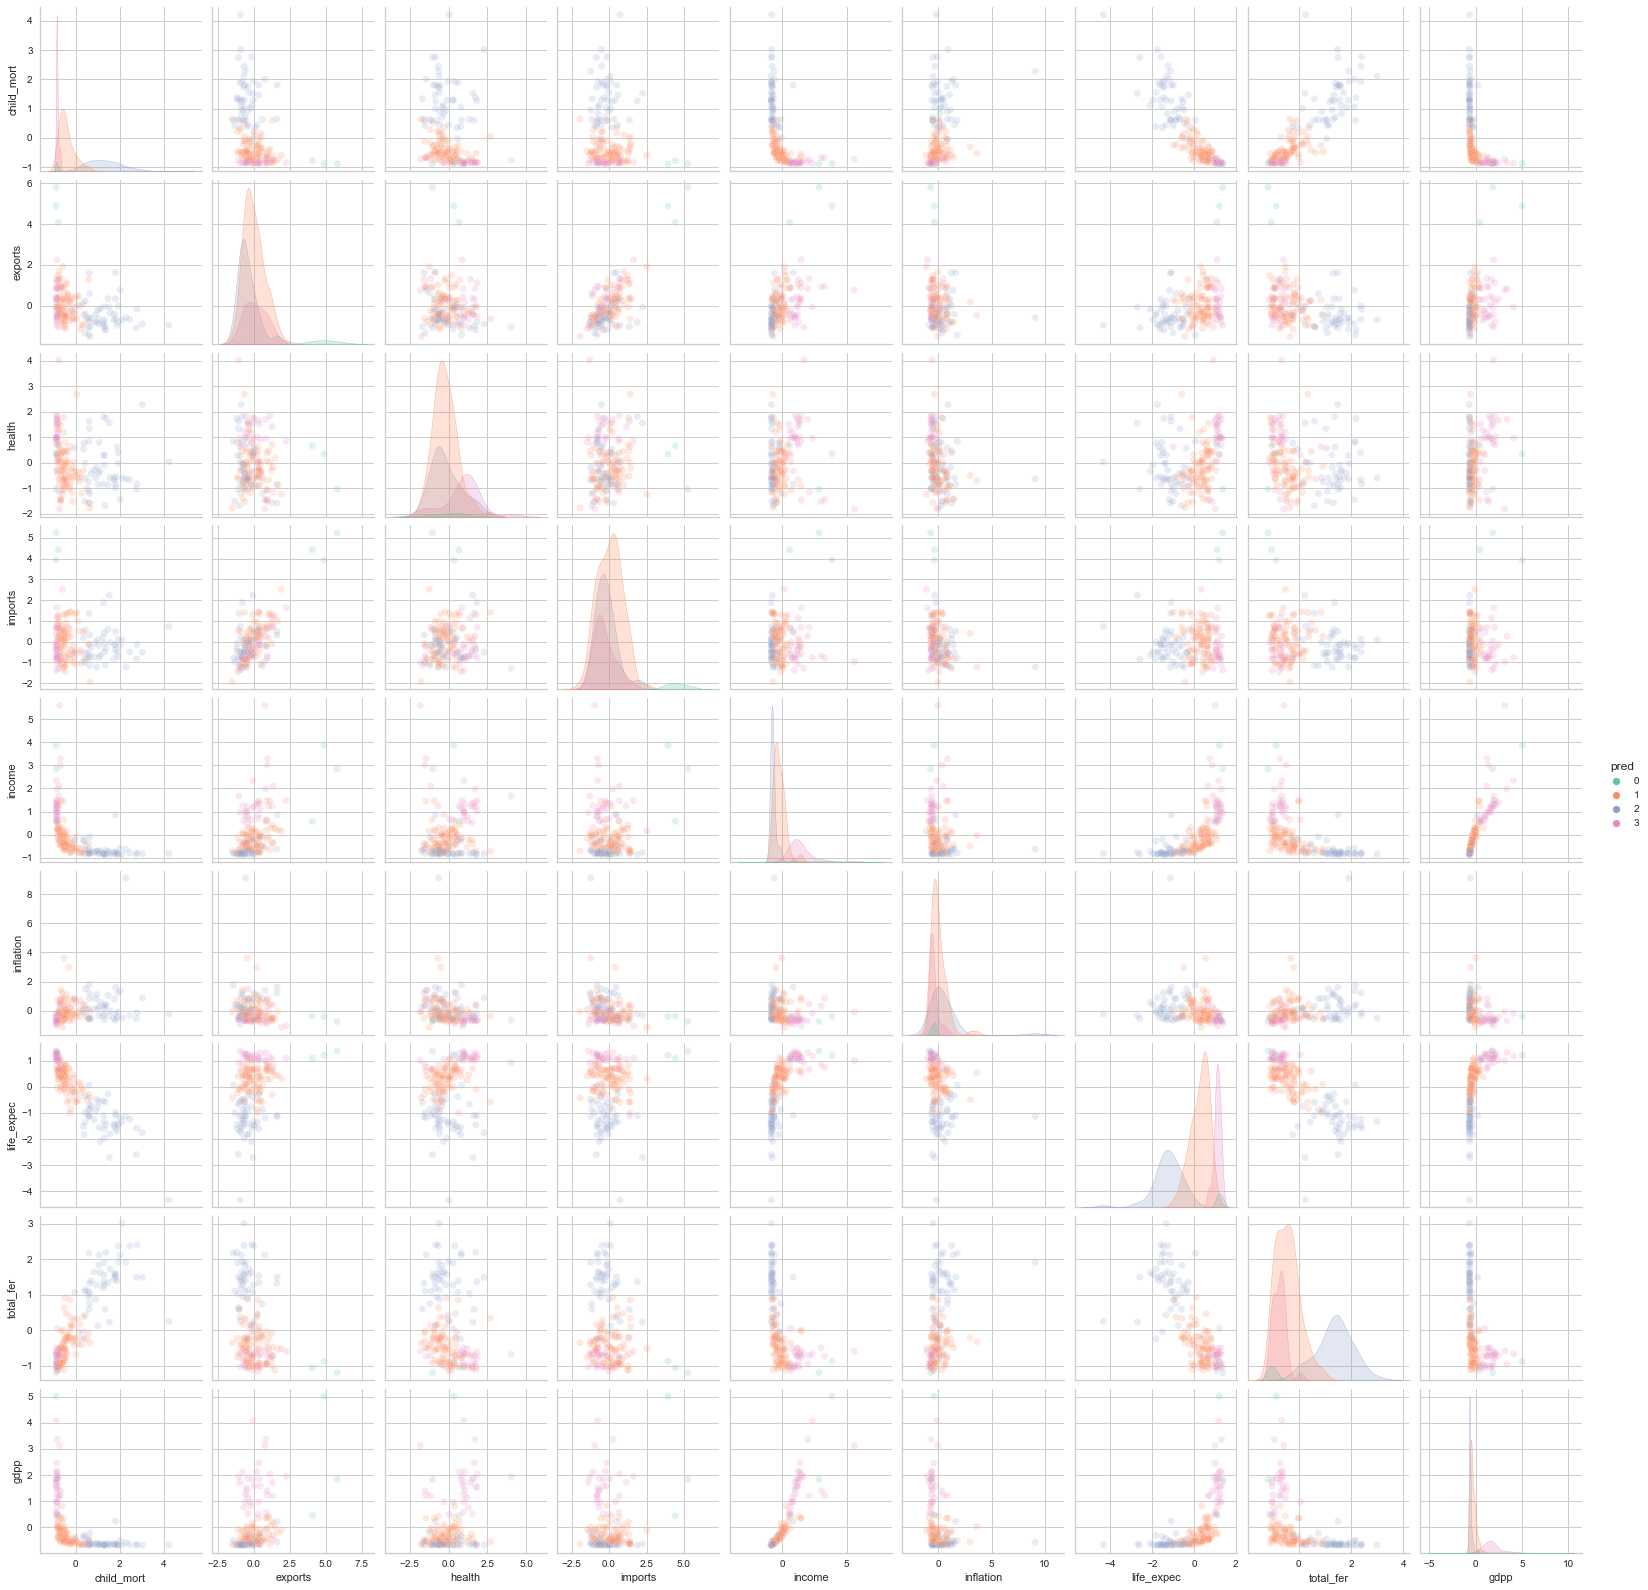

In [11]:
# tsne cluster plot with k=3
kmeans = KMeans(n_clusters=4, n_init=150)
kmeans.fit(df.drop('country', axis=1))

temp=df.drop('country', axis=1)
temp['pred']=kmeans.predict(df.drop('country', axis=1))

plt.figure(figsize=(10,10))
sns.scatterplot(
    x=tsne_obj[:,0], y=tsne_obj[:,1], hue=temp['pred'],
    palette=sns.color_palette("Set2"))
plt.show()

plt.figure(figsize=(10,10))
sns.pairplot(temp, plot_kws={'alpha': 0.2}, hue='pred',
             palette=sns.color_palette("Set2"))
plt.show()

In [16]:
temp['pred'].value_counts()

1    87
2    47
3    30
0     3
Name: pred, dtype: int64

2 0.25795411295270215
3 0.1923308494653843
4 0.21107841153090723
5 0.21645751580339034
6 0.14539645143185484
7 0.15793643661219034
8 0.18499956213568522
9 0.16496524365700546
10 0.15716691697113894


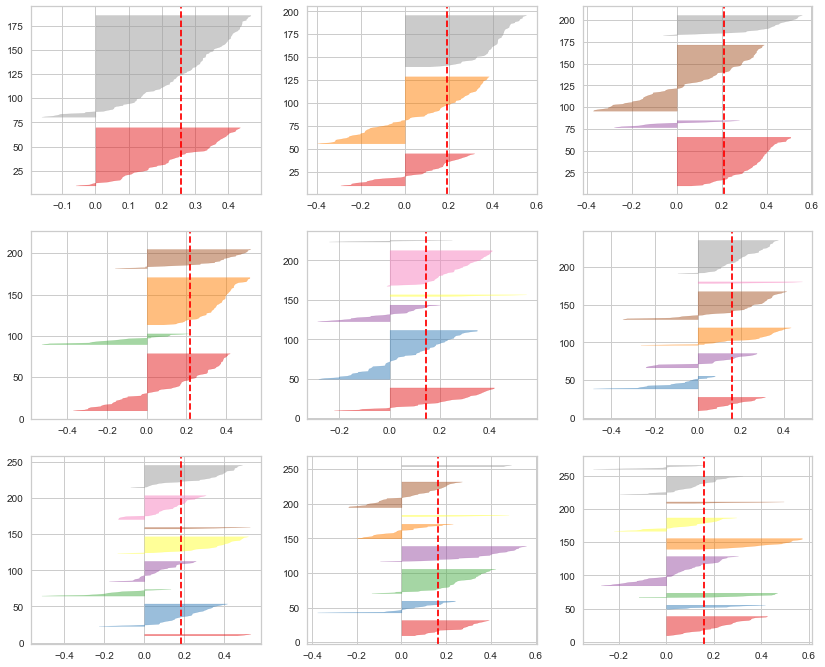

In [17]:
# SilhouetteVisualizer for GaussianMixture
from sklearn.mixture import GaussianMixture
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.base import ClusterMixin

class GMClusters(GaussianMixture, ClusterMixin):
    def __init__(self, n_clusters=1, **kwargs):
        kwargs["n_components"] = n_clusters
        self.n_clusters=n_clusters
        super(GMClusters, self).__init__(**kwargs)

    def fit(self, X, y=None):
        super().fit(X)
        self.labels_ = self.predict(X)
        return self

    def get_params(self, **kwargs):
        output = super().get_params(**kwargs)
        output["n_clusters"] = output.get("n_components", None)
        return output

    def set_params(self, **kwargs):
        kwargs["n_components"] = kwargs.pop("n_clusters", None)
        return super().set_params(**kwargs)

plt.figure(figsize=(14,20))
for k in range(2,11):
    plt.subplot(5, 3, k - 1)
    visualizer = SilhouetteVisualizer(
        GMClusters(k,max_iter=1000), force_model=True)
    visualizer.fit(df.drop('country', axis=1))
    print(k, visualizer.silhouette_score_)
    # visualizer.show()


C:\Users\No1\AppData\Local\Temp\ipykernel_4376\2739028282.py:9: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  sns.scatterplot(


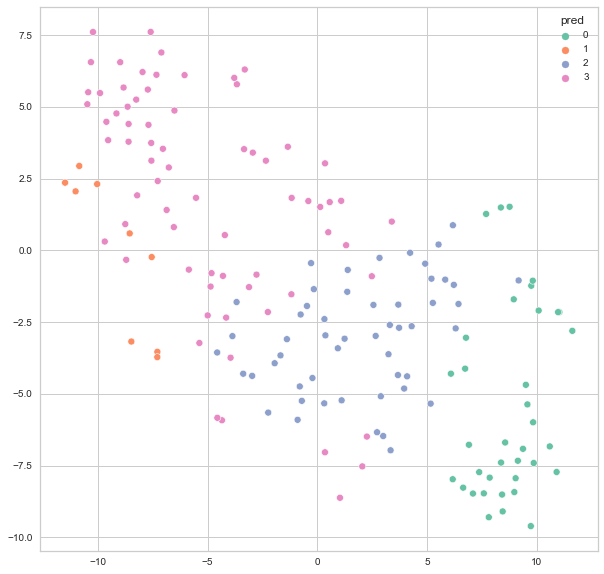

E:\User Applications\Software\Miniconda3\envs\SpikingJelly\lib\site-packages\seaborn\axisgrid.py:1507: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  func(x=vector, **plot_kwargs)
E:\User Applications\Software\Miniconda3\envs\SpikingJelly\lib\site-packages\seaborn\axisgrid.py:1507: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  func(x=vector, **plot_kwargs)
E:\User Applications\Software\Miniconda3\envs\SpikingJelly\lib\site-packages\seaborn\axisgrid.py:1507: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  func(x=vector, **plot_kwargs)
E:\User Applications\Software\Miniconda3\envs\SpikingJelly\lib\site-packages\seaborn\axisgrid.py:1507: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  func(x=vector, **plot_kwargs)
E:\User Applications\Software\Miniconda3\envs\SpikingJelly\lib\site-packages\seaborn

<Figure size 720x720 with 0 Axes>

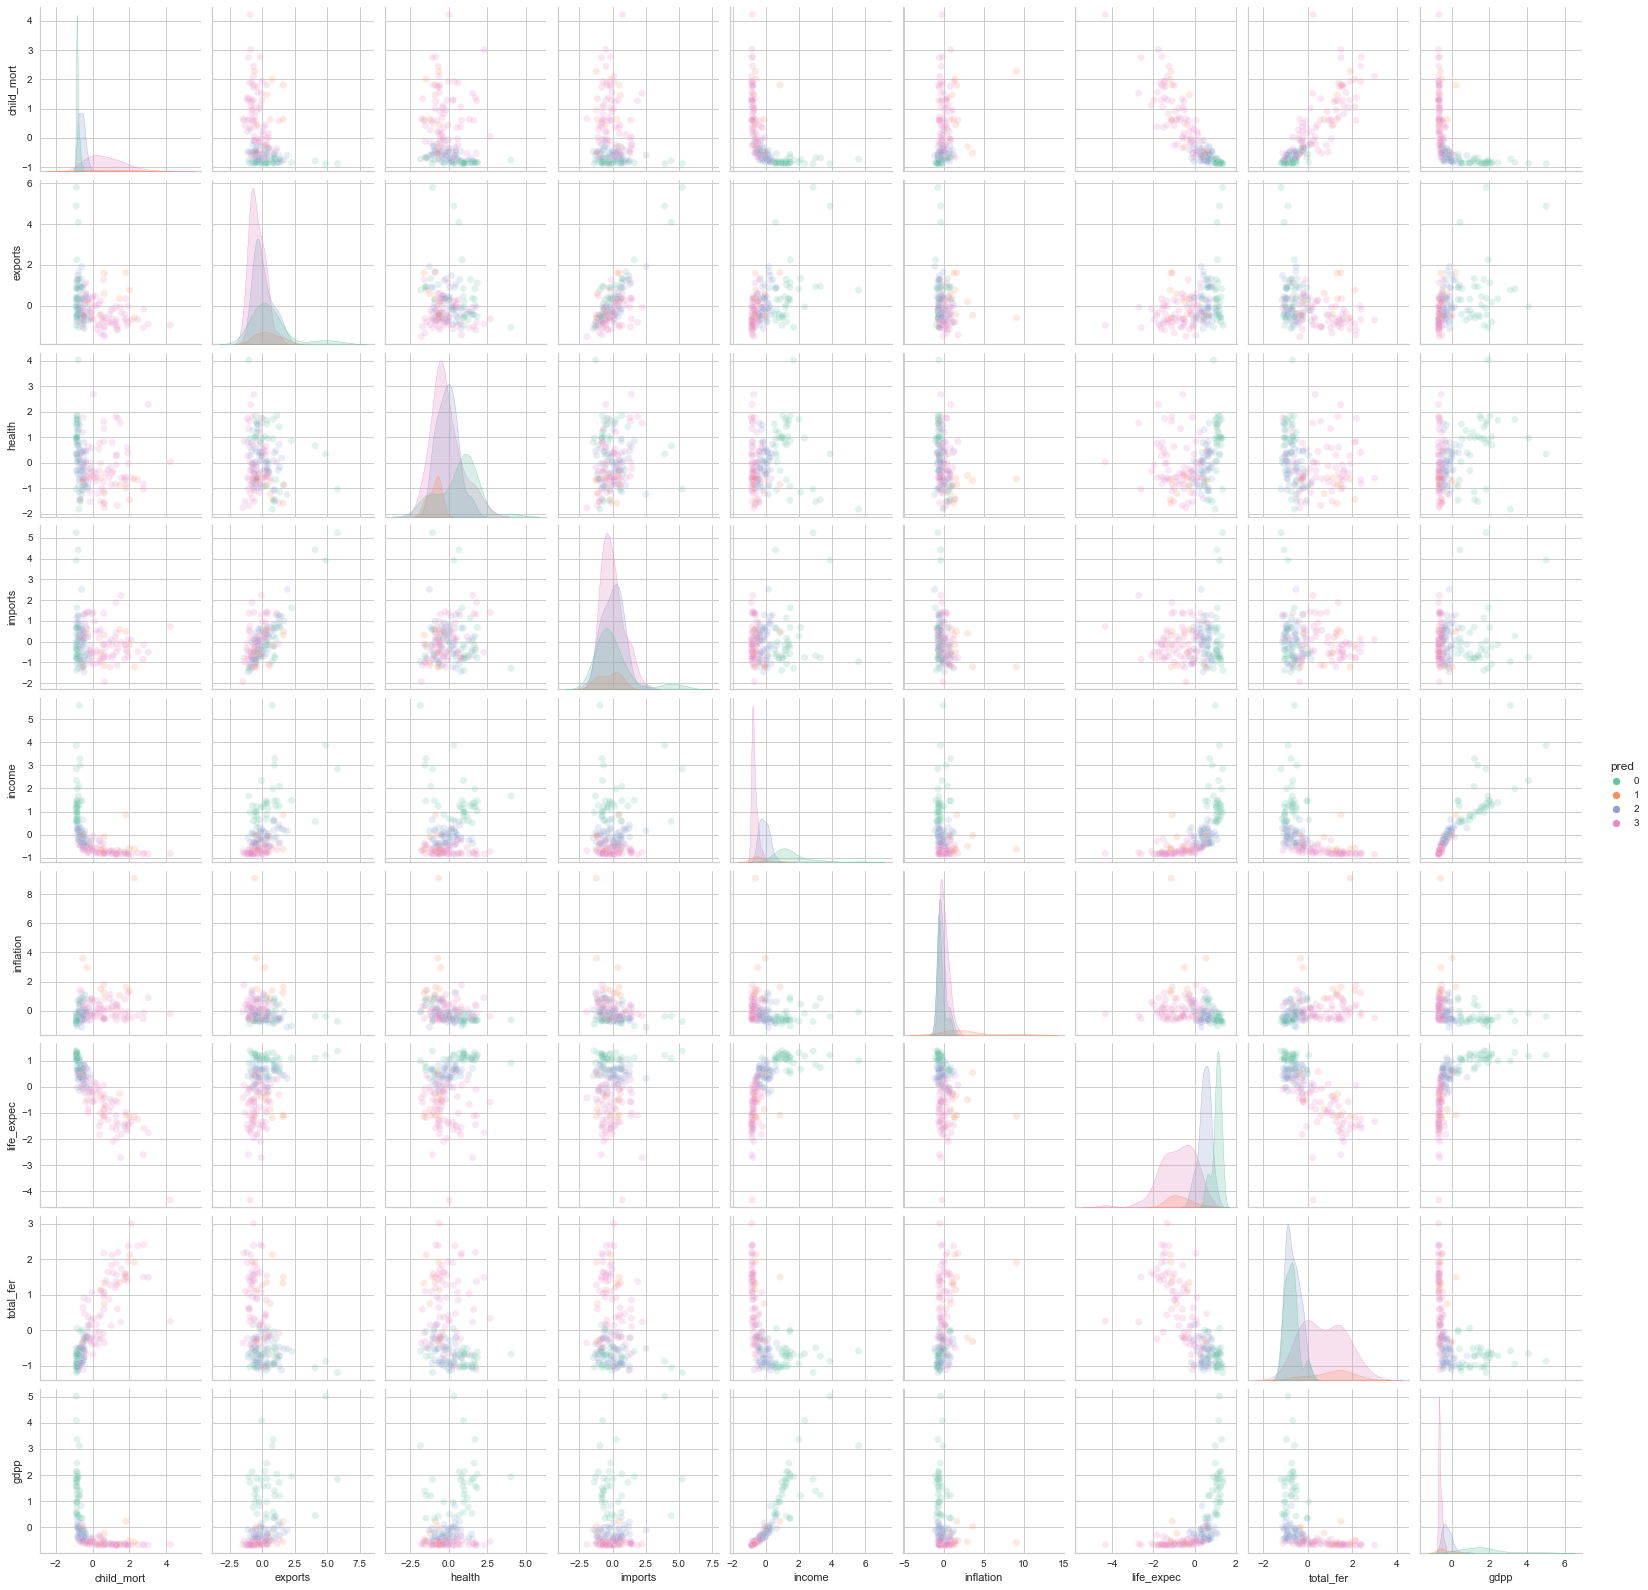

In [18]:
# tsne cluster plot with k=3
kmeans = GMClusters(n_clusters=4, max_iter=1000)
kmeans.fit(df.drop('country', axis=1))

temp=df.drop('country', axis=1)
temp['pred']=kmeans.predict(df.drop('country', axis=1))

plt.figure(figsize=(10,10))
sns.scatterplot(
    x=tsne_obj[:,0], y=tsne_obj[:,1], hue=temp['pred'],
    palette=sns.color_palette("Set2"))
plt.show()

plt.figure(figsize=(10,10))
sns.pairplot(temp, plot_kws={'alpha': 0.2}, hue='pred',
             palette=sns.color_palette("Set2"))
plt.show()

In [19]:
temp['pred'].value_counts()

3    70
2    52
0    36
1     9
Name: pred, dtype: int64